# Versions

* **2.0 -** Added effnet b2, changed transform size to 256, added more transforms: HorizontalFlip(), VerticalFlip(), ColorJitter(brightness=32. / 255.,saturation=0.5,hue=0.01)

* **3.0 -** Added Hairs for augmentation and Microscope, Changed final prediction plot

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from PIL import Image
import gc

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

!pip install torchtoolbox
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset


import time
import datetime
import random

from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

import os 

import warnings
warnings.simplefilter('ignore')

     |████████████████████████████████| 58 kB 451 kB/s 
     |████████████████████████████████| 869 kB 1.4 MB/s 
  Created wheel for lmdb: filename=lmdb-0.98-cp37-cp37m-linux_x86_64.whl size=273143 sha256=f56721f9008296c12f353c520c8de854bc48c9f420da80fa7bf2b61bdeae5501
  Stored in directory: /root/.cache/pip/wheels/9e/24/96/783d4dddcf63e3f8cc92db8b3af3c70cf6d76398bff77f1d5e
Successfully built lmdb
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=a56e24282606c14a61c68aa7fc5148ba38be6176317f2a94ee971281390e4e9c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Seeds

In [2]:
# Creating seeds to make results reproducible
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 1234
seed_everything(seed)

# Setting up the Device 

In [3]:
# Setting up GPU for processing or CPU if GPU isn't available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


# Loading the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook. The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as  random scaling, cropping, and flipping. This will help the network generalize leading to better performance. The input data must be resized to 256x256 pixels as required by the pre-trained networks (in this case the images are already 256x256).

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this no scaling or rotation transformations will be applied, but the images still need to be resized and then croped to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

## Creating Custom Dataset Class

In [4]:
class CustomDataset(Dataset):
  def __init__(self, df: pd.DataFrame, img_dir, train: bool = True, transforms= None):
    self.df = df
    self.img_dir = img_dir
    self.transforms = transforms
    self.train = train

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.df.iloc[index]['image_name'] + '.jpg')
    #images = Image.open(img_path)
    images = cv2.imread(img_path)

    if self.transforms:
        images = self.transforms(images)

    if self.train:
        labels = self.df.iloc[index]['target']
        #return images, labels
        return torch.tensor(images, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)
    
    else:
        #return (images)
        return torch.tensor(images, dtype=torch.float32)
    
  def __len__(self):
        return len(self.df)

## Creating Dataframes and image directories

In [5]:
df = pd.read_csv('/kaggle/input/melanoma-external-malignant-256/train_concat.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
test_img_dir = '/kaggle/input/melanoma-external-malignant-256/test/test/'
train_img_dir = '/kaggle/input/melanoma-external-malignant-256/train/train/'

## Creating Validation Data from the Training Data 
Because there is no validation dataset we have to split the training set into training and validation set

In [6]:
vld_size=0.20

train, valid = train_test_split (df, stratify=df.target, test_size = vld_size, random_state=42) 

train_df=pd.DataFrame(train)
validation_df=pd.DataFrame(valid)

print(len(validation_df))
print(len(train_df))

7530
30118


In [7]:
#skf = StratifiedKFold(n_splits=5)
#for fold, (train_ix, val_ix) in enumerate(skf.split(df['image_name'].to_numpy(), df['target'].to_numpy())): 

 #print(len(train_ix), len(val_ix))                                      


In [8]:
#train_df = df.iloc[train_ix].reset_index(drop=True)
#validation_df = df.iloc[val_ix].reset_index(drop=True)

## Distribution of Targets in Training and Validation sets
Targets (in this case melanoma images) should be equally distributed

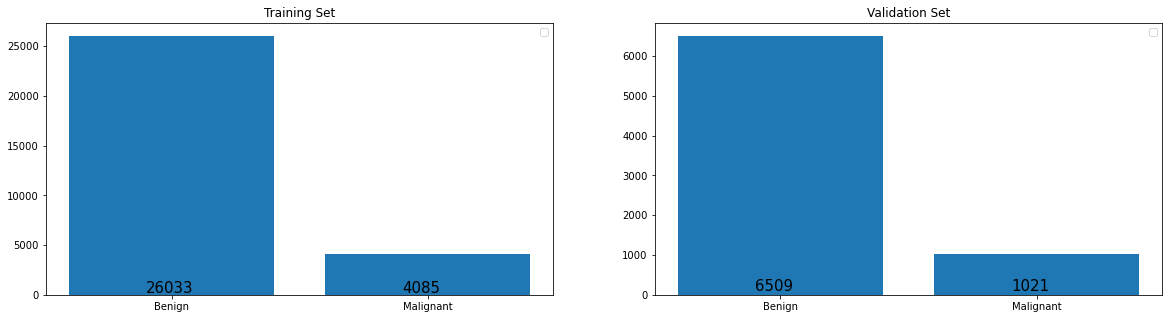

In [9]:
fig2 = plt.figure(figsize=(20, 5))
ax3 = fig2.add_subplot(1,2,1)
ax4 = fig2.add_subplot(1,2,2)

counts1 = train_df['target'].value_counts()
dx = ['Benign', 'Malignant']
ax3.bar(dx, counts1)  
ax3.set_title("Training Set")
ax3.legend()

for i, v in enumerate(counts1):
    ax3.text(i-.1, 
              v/counts1[i]+200, 
              counts1[i], 
              fontsize=15,
              )


counts2 = validation_df['target'].value_counts()
ax4.bar(dx, counts2)  
ax4.set_title("Validation Set")
ax4.legend()

for i, v in enumerate(counts2):
    ax4.text(i-.1, 
              v/counts2[i]+100, 
              counts2[i], 
              fontsize=15)
 

plt.show()  

## Defining Transformations

### Defining random hairs simulation and microscope view for augmentation

In [10]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = "../input/melanoma-hairs"):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

class DrawHair:
    """
    Draw a random number of pseudo hairs

    Args:
        hairs (int): maximum number of hairs to draw
        width (tuple): possible width of the hair in pixels
    """

    def __init__(self, hairs:int = 4, width:tuple = (1, 2)):
        self.hairs = hairs
        self.width = width

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        if not self.hairs:
            return img
        
        width, height, _ = img.shape
        
        for _ in range(random.randint(0, self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line 
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(img, origin, end, color, random.randint(self.width[0], self.width[1]))
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, width={self.width})'


In [11]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'



### Setting up transformations

In [12]:
# Defining transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([#Microscope(),
                                          AdvancedHairAugmentation(),
                                          transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ColorJitter(brightness=32. / 255.,saturation=0.5,hue=0.01),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(256),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(256),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

## Loading Datasets

In [13]:
# Loading the datasets with the transforms previously defined
training_dataset = CustomDataset(df = train_df,
                                 img_dir = train_img_dir, 
                                 train = True,
                                 transforms = training_transforms )

validation_dataset = CustomDataset(df = validation_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = training_transforms )

testing_dataset = CustomDataset(df = test_df,
                                img_dir = test_img_dir,
                                train= False, 
                                transforms = testing_transforms )

## Defining Dataloaders

In [14]:
# Using the image datasets with the transforms, defining the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, num_workers=4, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle = False)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=16, shuffle = False)

In [15]:
print(len(train_loader))
print(len(validate_loader))
print(len(test_loader))

942
471
687


## Figuring out how much time the Transformations take

In [16]:
transform_start = time.time()
for i, data in enumerate(train_loader):
    images = data
end = time.time()
time_spent = (end-transform_start)/60
print(f"{time_spent:.3} minutes")

4.17 minutes


# Building the Model

Now that the data is ready, it's time to build the Model. I will be using a pretrained model 'Efficient Net' to get the image features and then modify it to fit the Dataset

In [17]:
class Net(nn.Module):
    def __init__(self, arch):
        super(Net, self).__init__()
        self.arch = arch
        if 'fgdf' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):   
            self.arch._fc = nn.Linear(in_features=1408, out_features=500, bias=True)
            #self.dropout1 = nn.Dropout(0.2)
            
        self.ouput = nn.Linear(500, 1)
        
    def forward(self, images):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x = images
        features = self.arch(x)
        output = self.ouput(features)
        
        return output

In [18]:
arch = EfficientNet.from_pretrained('efficientnet-b2')
model = Net(arch=arch)  
model = model.to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [19]:
# If we need to freeze the pretrained model parameters to avoid backpropogating through them, turn to "False"
for parameter in model.parameters():
    parameter.requires_grad = True

In [20]:
#Total Parameters (If the model is unfrozen the trainning params will be the same as the Total params)
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

8,405,995 total parameters.
8,405,995 training parameters.


# Hyperparameters

Easier for later tunning

In [21]:
# Empty variable to be stored with best validation accuracy
best_val = 0

# Path and filename to save model to
model_path = f'melanoma_model_{best_val}.pth'  

# Number of Epochs
epochs = 10

# Early stopping if no change in accurancy
es_patience = 3

# Loss Function:
criterion = nn.BCEWithLogitsLoss()

# Optimizer (gradient descent):
optimizer = optim.Adam(model.parameters(), lr=0.0005) 

# Scheduler
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=1, verbose=True, factor=0.2)







# Trainning the Model

In [22]:
#from workspace_utils import active_session -> this can be used so that the session remains on and not disconnect

  
loss_history=[]  
train_acc_history=[]  
val_loss_history=[]  
val_acc_history=[] 
val_auc_history=[]

    
patience = es_patience
Total_start_time = time.time()  
model.to(device)

for e in range(epochs):
    
    start_time = time.time()
    correct = 0
    running_loss = 0
    model.train()
    
    for images, labels in train_loader:
        
        
        images, labels = images.to(device), labels.to(device)
            
        
        optimizer.zero_grad()
        
        output = model(images) 
        loss = criterion(output, labels.view(-1,1))  
        loss.backward()
        optimizer.step()
        
        # Training loss
        running_loss += loss.item()

        # Number of correct training predictions and training accuracy
        train_preds = torch.round(torch.sigmoid(output))
            
        correct += (train_preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()
                        
    train_acc = correct / len(train_df)
        
        
    #switching to validation:        
    model.eval()
    preds=[]            
    # Turning off gradients for validation, saves memory and computations
    with torch.no_grad():
        
        val_loss = 0
        val_correct = 0
    
        for val_images, val_labels in validate_loader:
         
        
            val_images, val_labels = val_images.to(device), val_labels.to(device)

        
            val_output = model(val_images)
            val_loss += (criterion(val_output, val_labels.view(-1,1))).item() 
            val_pred = torch.sigmoid(val_output)
            
            preds.append(val_pred.cpu())
        pred=np.vstack(preds).ravel()
           
        #val_accuracy = accuracy_score(train_df['target'].values, torch.round(pred2))
        val_auc_score = roc_auc_score(validation_df['target'].values, pred)
            
        training_time = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Training Accuracy: {:.3f}..".format(train_acc),
              "Validation Loss: {:.3f}.. ".format(val_loss/len(validate_loader)),
              #"Validation Accuracy: {:.3f}".format(val_accuracy),
              "Validation AUC Score: {:.3f}".format(val_auc_score),
              "Training Time: {}".format( training_time))
            
          
        scheduler.step(val_auc_score)
                
        if val_auc_score >= best_val:
            best_val = val_auc_score
            patience = es_patience  # Resetting patience since we have new best validation accuracy
            torch.save(model, model_path)  # Saving current best model
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                break
        
    loss_history.append(running_loss)  
    train_acc_history.append(train_acc)    
    val_loss_history.append(val_loss)  
    #val_acc_history.append(val_accuracy)
    val_auc_history.append(val_auc_score)
    

total_training_time = str(datetime.timedelta(seconds=time.time() - Total_start_time  ))[:7]                  
print("Total Training Time: {}".format(total_training_time))
                  
              

Epoch: 1/10..  Training Loss: 0.142..  Training Accuracy: 0.953.. Validation Loss: 0.120..  Validation AUC Score: 0.974 Training Time: 0:07:51
Epoch: 2/10..  Training Loss: 0.110..  Training Accuracy: 0.965.. Validation Loss: 0.105..  Validation AUC Score: 0.976 Training Time: 0:07:34
Epoch: 3/10..  Training Loss: 0.097..  Training Accuracy: 0.969.. Validation Loss: 0.097..  Validation AUC Score: 0.980 Training Time: 0:07:35
Epoch: 4/10..  Training Loss: 0.094..  Training Accuracy: 0.970.. Validation Loss: 0.088..  Validation AUC Score: 0.982 Training Time: 0:07:35
Epoch: 5/10..  Training Loss: 0.089..  Training Accuracy: 0.971.. Validation Loss: 0.085..  Validation AUC Score: 0.983 Training Time: 0:07:40
Epoch: 6/10..  Training Loss: 0.083..  Training Accuracy: 0.974.. Validation Loss: 0.093..  Validation AUC Score: 0.981 Training Time: 0:07:39
Epoch: 7/10..  Training Loss: 0.081..  Training Accuracy: 0.975.. Validation Loss: 0.094..  Validation AUC Score: 0.983 Training Time: 0:07:33

# Ploting losses and accuracies

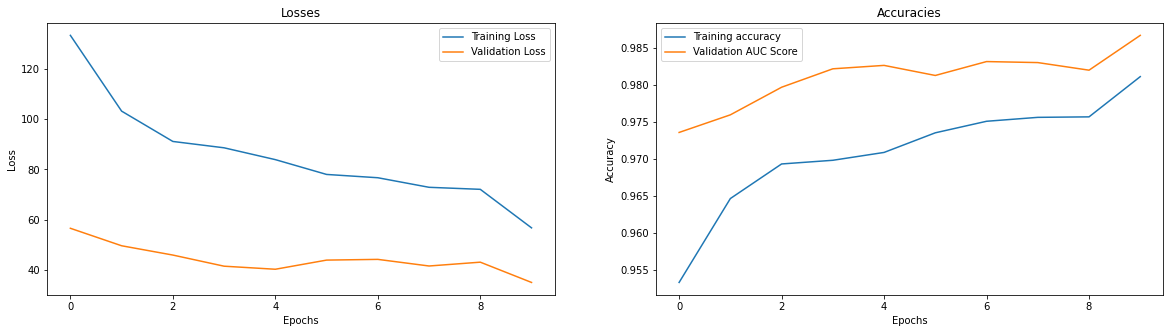

In [23]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(loss_history, label= 'Training Loss')  
ax1.plot(val_loss_history,label='Validation Loss')
ax1.set_title("Losses")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_acc_history,label='Training accuracy')  
#ax2.plot(val_acc_history,label='Validation accuracy')
ax2.plot(val_auc_history,label='Validation AUC Score')
ax2.set_title("Accuracies")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()  

## Deleting unnecessary variables and cleaning up Cache

In [24]:
del training_dataset, validation_dataset, train_loader, validate_loader, images, val_images, val_labels
gc.collect()


25

# Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images. I will run the test images through the network and measure the accuracy, the same way I did validation. 

In [25]:
test_df['target']= np.zeros((len(test_df), 1))


In [26]:
test_labels = torch.tensor(test_df['target'], dtype=torch.float32)

In [27]:

model = torch.load(model_path)
model.eval()
model.to(device)
test_preds=[]
with torch.no_grad():
    
    
    
    for f, (test_images) in enumerate(test_loader):
        
        
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        
        
        test_output = model(test_images)
        test_pred = torch.sigmoid(test_output)
            
        test_preds.append(test_pred.cpu())
        
    test_pred=np.vstack(test_preds).ravel()
    test_pred2 = torch.tensor(test_pred)
    test_accuracy = accuracy_score(test_labels.cpu(), torch.round(test_pred2))
      
        
    
print("Test Accuracy: {}".format(test_accuracy))    
        

Test Accuracy: 0.9946275723911856


In [28]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
sub.loc[:, "target"] = test_pred
sub.to_csv('submission.csv', index=False)

###### Inference for classification

Writing a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the Image. 

Writing a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. 

First the input image needs to be processed in the same manner it was for training, so that it can be used in the network. 


## Image Preprocessing

Using `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as an input for the model. This function should process the images in the same manner used for training. 

If the Image is bigger than 256x256:..

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then crop out the center 256x256 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I'll need to convert the values. It's easiest with a Numpy array, which can be obtained from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Dimensions must be reordered using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [29]:
#from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-256)/2
    bottom_margin = (pil_image.height-256)/2
    right_margin = left_margin + 256
    top_margin = bottom_margin + 256
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
  
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image



Checking work done untill now, the function below converts a PyTorch tensor and displays it in the notebook. If `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

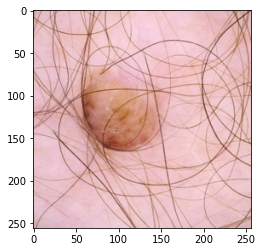

In [30]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0052060.jpg')
imshow(image)

# Class Prediction

Once the images are in the correct format, it's time to write a function to make predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. The indices need to be converted to the actual class labels using `class_to_idx` which was added to the model, it can also be done from an `ImageFolder` used to load the data ([see here](#Save-the-checkpoint)). 

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.


In [31]:
#model = torch.load('../input/melanoma-model/melanoma_model_0.pth' )
#model = model.to(device)
#model.eval()

In [32]:
# Implement the code to predict the class from an image file

def predict(image_path, model, topk=1): #just 2 classes from 1 single output
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model(image)
    
    probabilities = torch.sigmoid(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    top_classes = []
    
    if probabilities > 0.5 :
        top_classes.append("Melanoma")
    else:
        top_classes.append("Benign")

    
    return top_probabilities, top_classes

predict_image_path='../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0502582.jpg'
#predict_image_path='../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0074618.jpg'

probs, classes = predict(predict_image_path, model)   
print(probs)
print(classes)

[0.6905391812324524]
['Melanoma']


# Confusion Matrix

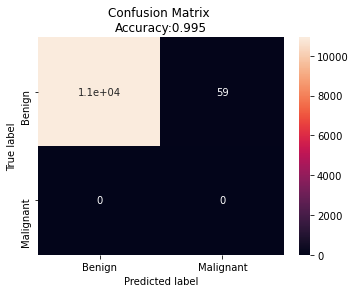

In [33]:
test = test_df['target']= np.zeros((len(test_df), 1))
pred = np.round(test_pred)
cm = confusion_matrix(test, pred)

cm_df = pd.DataFrame(cm,
                     index = ['Benign','Malignant'], 
                     columns = ['Benign','Malignant'])

plt.figure(figsize=(5.5,4))
sb.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix \nAccuracy:{0:.3f}'.format(test_accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Sanity Check

Now that we can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Using `matplotlib` to plot the diagnosis along with the input image. 

Introduce the image path to be predicted in "predict_image_path" object above


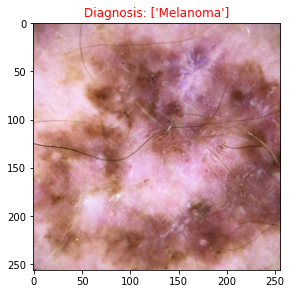

In [34]:
# Display an image along with the diagnosis of melanoma or benign

# Plot Skin image input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

image = process_image(predict_image_path)

imshow(image, plot_1)
font = {"color": 'g'} if 'Benign' in classes else {"color": 'r'}
plot_1.set_title("Diagnosis: {}".format(classes), fontdict=font);